In [8]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

In [4]:
uploaded=files.upload()

Saving sign_mnist_train.csv to sign_mnist_train.csv


In [5]:
uploaded=files.upload()

Saving sign_mnist_test.csv to sign_mnist_test (2).csv


In [13]:
train = pd.read_csv('sign_mnist_test (2).csv')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [14]:
def get_data(filename):
    
  # Each successive line contians 785 comma separated values between 0 and 255
  # The first value is the label
  # The rest are the pixel values for that picture
  # The function will return 2 np.array types. The labels and images
  # We have to convert the values from string to 'float'

    with open(filename) as file:        
        csv_reader = csv.reader(file)  
        next(csv_reader)  # to skip the headers
        
        images = []
        labels = []
        
        for row in csv_reader:
            images.append(np.array(row[1:]).reshape(28, 28))
            labels.append(row[0]) # first value is label

    images = np.array(images).astype(np.float32) 
    labels = np.array(labels).astype(np.float32)
    
    return images, labels

mnist_train = "sign_mnist_train.csv"
mnist_test = "sign_mnist_test (2).csv"
training_images, training_labels = get_data(mnist_train)
testing_images, testing_labels = get_data(mnist_test)

# Keep these
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)


(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [15]:
# We have to add another dimension to the data
# for example : from (10000, 28, 28) to (10000, 28, 28, 1)
# Because images have 3 dimension (m, n_x, n_y, d)

training_images = np.expand_dims(training_images,axis=3)
testing_images = np.expand_dims(testing_images,axis=3)

# Create an ImageDataGenerator and do Image Augmentation
# Because we have relatively little dataset for training 

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

validation_datagen = ImageDataGenerator(
    rescale=1.0/255.0)
    
# Keep These
print(training_images.shape)
print(testing_images.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [18]:
# Create a callback to stop when accuracy reached 90%

class myCallback(tf.keras.callbacks.Callback):
  def on_eponch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.90):
      print("\n Reached 90% accuracy, so cancelling training. ")
      self.model.stop_training = True

In [20]:
# Define the model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
    
])

# Compile Model. 
model.compile(optimizer = 'adam',
              loss ='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# We didn't use datagenerator labeling so, 
# we will use .flow methode to create generator

train_generator = train_datagen.flow(
    training_images,
    training_labels,
    batch_size=32)
validation_generator = validation_datagen.flow(
    testing_images,
    testing_labels,
    batch_size=32)

callbacks = myCallback()

# Train the Model
history = model.fit_generator(train_generator,
                              #steps_per_epoch = len(training_images)/32,
                              #validation_steps = len(testing_images)/32,
                              epochs = 10,
                              validation_data = validation_generator,
                              callbacks = [callbacks])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
858/858 [==============================] - 50s 57ms/step - loss: 2.8645 - accuracy: 0.1356 - val_loss: 1.6046 - val_accuracy: 0.4497
Epoch 2/10
858/858 [==============================] - 49s 58ms/step - loss: 1.7741 - accuracy: 0.4319 - val_loss: 0.8386 - val_accuracy: 0.7227
Epoch 3/10
858/858 [==============================] - 49s 58ms/step - loss: 1.2731 - accuracy: 0.5870 - val_loss: 0.6246 - val_accuracy: 0.7922
Epoch 4/10
858/858 [==============================] - 49s 57ms/step - loss: 0.9742 - accuracy: 0.6794 - val_loss: 0.4794 - val_accuracy: 0.8185
Epoch 5/10
858/858 [==============================] - 49s 57ms/step - loss: 0.8162 - accuracy: 0.7302 - val_loss: 0.3427 - val_accuracy: 0.8936
Epoch 6/10
858/858 [==============================] - 49s 57ms/step - loss: 0.6641 - accuracy: 0.7790 - val_loss: 0.2719 - val_accuracy: 0.9184
Epoch 7/10
858/858 [==============================] - 49s 57ms/step - loss: 0.5864 - accuracy: 0.8071 - val_loss: 0.2390 - val_accuracy:

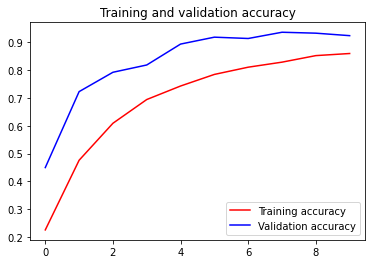

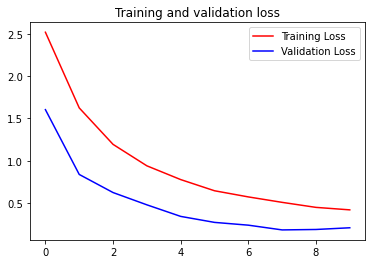

In [21]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()